# Portfolio optimization and performance evaluation
1.   10-year monthly price data for 10 US stocks+10 foreign stocks
2.   use 1st-five year data to obtain target weights (in-sample analysis)
3.   use 2nd-five year data for perform eval analysis (out-of-sampe analysis)

# Portfolios to be considered
1.   minimum variance
2.   max sharpe ratio
3.   max utility
4.   value-weighted

# Install Python project for Portfolio Optimization

In [1]:
pip install PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 8.3 MB/s eta 0:00:00


# Install libraries

In [2]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas.tseries.offsets import *
import datetime
pd.options.mode.chained_assignment = None  # turnoff false postive warning

# Connect Google drive to Colab

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Change the working directory to the project folder

In [4]:
#Make sure to create a folder named "Project" inside the course folder "GI" on your Google Drive
# and save all your Python code and project data there.
import os
os.chdir('/content/drive/MyDrive/GI/Project')

# Define the sample to be used for portfolio analysis

In [5]:
sample = 'US'
sample = 'GLOBAL'

# Create a new folder named 'Output' under the current working directory

In [6]:
current_dir = os.getcwd()  # Get the current working directory

if sample == 'US':
    output_folder_path = os.path.join(current_dir, 'Output_US')
    os.makedirs(output_folder_path, exist_ok=True)  # prevents errors if the folder already exists
elif sample == 'GLOBAL':
    output_folder_path = os.path.join(current_dir, 'Output_GLOBAL')
    os.makedirs(output_folder_path, exist_ok=True)
else:
    print('Sample name is not provided')

# Define estimation & evaluation periods

In [7]:
est_begyr=2015 #first year of estimation period
est_endyr=2019 #last year of estimation period
eva_begyr=2020 #first year of evaluation period
eva_endyr=2024 #last year of evaluation period

# Read in stock price/return data

In [8]:
#import month-end prices for 12/2014-12/2024 (121 monthly obs for each stock)
prc_raw = pd.read_csv("stock_prices.csv", parse_dates=True)
prc_raw.columns = map(str.lower, prc_raw.columns)#convert variable names to lower cases
prc_raw['date'] = pd.to_datetime(prc_raw['date'])+MonthEnd(0) #last calendar day of a month
if sample == 'US':
   prc = prc_raw.iloc[:, list(range(0, 11))]  #portfolio formed using the first 10 US stocks;
elif sample == 'GLOBAL':
   prc = prc_raw.copy()  #portfolio formed using all stocks, including 10 US stocks and 5 foreign stocks;
else:
    print('Sample name is not provided')
prc

<ipython-input-8-a3ab416e9b71>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  prc_raw['date'] = pd.to_datetime(prc_raw['date'])+MonthEnd(0) #last calendar day of a month


,date,apple inc. (xnas:aapl),jpmorgan chase & co. (xnys:jpm),exxon mobil corporation (xnys:xom),pfizer inc. (xnys:pfe),the procter & gamble company (xnys:pg),"the home depot, inc. (xnys:hd)",caterpillar inc. (xnys:cat),"tesla, inc. (xnas:tsla)",at&t inc. (xnys:t),...,novo nordisk a/s (xnys:nvo),sony group corporation (xnys:sony),sap se (xetr:sap),bp p.l.c. (xnys:bp),nestle ltd. (otcm:nsrgy),ypf sa (xnys:ypf),vale sa (bvmf:vale3),icici bank limited (xnys:ibn),"pacific airport group, s.a.b. de cv (xnys:pac)",pt telkom indonesia (persero) tbk (xnys:tlk)
0,2014-12-31,28.75,62.70,93.82,30.32,90.38,99.64,98.78,14.91,25.63,...,23.17,4.43,56.20,39.98,74.06,30.84,19.00,11.14,63.44,22.69
1,2015-01-31,27.33,62.49,92.83,29.70,90.44,103.43,91.88,14.62,25.58,...,21.25,4.11,57.79,38.12,72.65,26.11,18.47,11.01,60.52,22.14
2,2015-02-28,29.73,57.89,91.50,31.44,85.61,109.04,83.21,14.49,26.33,...,21.22,5.31,59.40,41.17,76.57,24.88,17.73,9.98,67.17,21.78
3,2015-03-31,31.65,60.89,85.63,32.20,82.66,114.45,80.06,12.93,25.28,...,23.26,5.50,63.28,40.35,77.08,26.47,17.01,10.40,61.10,22.36
4,2015-04-30,31.33,60.52,84.30,32.59,82.43,114.54,80.24,12.73,25.02,...,27.24,5.57,67.34,39.65,76.40,28.13,15.63,9.72,65.78,21.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#calculate monthly returns
ret = prc.copy() #copy the data structure of the "prc" file
ret.iloc[:, 1:] = (prc.iloc[:, 1:]-prc.iloc[:, 1:].shift())/prc.iloc[:, 1:].shift() #calculate return
ret = ret.dropna() #drop obs with missing return data
ret

,date,apple inc. (xnas:aapl),jpmorgan chase & co. (xnys:jpm),exxon mobil corporation (xnys:xom),pfizer inc. (xnys:pfe),the procter & gamble company (xnys:pg),"the home depot, inc. (xnys:hd)",caterpillar inc. (xnys:cat),"tesla, inc. (xnas:tsla)",at&t inc. (xnys:t),...,novo nordisk a/s (xnys:nvo),sony group corporation (xnys:sony),sap se (xetr:sap),bp p.l.c. (xnys:bp),nestle ltd. (otcm:nsrgy),ypf sa (xnys:ypf),vale sa (bvmf:vale3),icici bank limited (xnys:ibn),"pacific airport group, s.a.b. de cv (xnys:pac)",pt telkom indonesia (persero) tbk (xnys:tlk)
1,2015-01-31,-0.049391,-0.003349,-0.010552,-0.020449,0.000664,0.038037,-0.069852,-0.019450,-0.001951,...,-0.082866,-0.072235,0.028292,-0.046523,-0.019039,-0.153372,-0.027895,-0.011670,-0.046028,-0.024240
2,2015-02-28,0.087816,-0.073612,-0.014327,0.058586,-0.053406,0.054240,-0.094362,-0.008892,0.029320,...,-0.001412,0.291971,0.027859,0.080010,0.053957,-0.047108,-0.040065,-0.093551,0.109881,-0.016260
3,2015-03-31,0.064581,0.051822,-0.064153,0.024173,-0.034459,0.049615,-0.037856,-0.107660,-0.039878,...,0.096136,0.035782,0.065320,-0.019917,0.006661,0.063907,-0.040609,0.042084,-0.090368,0.026630
4,2015-04-30,-0.010111,-0.006077,-0.015532,0.012112,-0.002782,0.000786,0.002248,-0.015468,-0.010285,...,0.171109,0.012727,0.064159,-0.017348,-0.008822,0.062713,-0.081129,-0.065385,0.076596,-0.040250
5,2015-05-31,0.029046,0.051058,0.053974,-0.008592,-0.025961,-0.043566,0.088858,0.183818,0.038769,...,0.049192,0.109515,0.017969,0.090290,0.022775,0.100249,0.271273,0.012346,0.061569,-0.046598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2024-08-31,-0.028629,-0.027589,0.030961,0.084848,0.029478,0.062317,-0.022781,-0.174340,0.031966,...,-0.104516,-0.059908,-0.015443,-0.080162,0.007531,-0.096614,-0.065930,-0.038317,-0.007287,-0.048265
117,2024-09-30,0.004366,0.066888,-0.036277,-0.061453,0.032397,0.012998,0.026459,0.014735,0.082602,...,0.028630,0.103554,0.024495,-0.063967,-0.003162,0.287211,-0.045880,0.016009,0.096430,0.117379
118,2024-10-31,0.027081,-0.005836,0.108221,0.000700,-0.038214,0.134176,0.205641,0.186732,0.044826,...,-0.122160,0.053304,0.052328,0.030721,-0.056912,-0.047537,0.102275,0.029762,0.032380,-0.046915
119,2024-11-30,-0.017152,0.055487,-0.079148,-0.017145,-0.022383,-0.038618,-0.043970,-0.004399,0.009585,...,-0.027623,-0.065366,0.079970,-0.111010,-0.033028,0.140737,-0.007215,0.032982,-0.037083,-0.064205


In [10]:
#import excess market return and risk-free rate (Ken French online data lib)
mktrf = pd.read_csv("mktrf.csv", parse_dates=True)
mktrf.columns = map(str.lower, mktrf.columns)#convert variable names to lower cases
mktrf['date'] = pd.to_datetime(mktrf['date'])+MonthEnd(0) #last calendar day of a month
mktrf

,date,mkt_rf,rf,unnamed: 3,mkt_rf.1,rf.1,unnamed: 6,unnamed: 7
0,2014-09-30,-0.0197,0.0,192607,2.96,0.22,0.0296,0.0022
1,2014-10-31,0.0252,0.0,192608,2.64,0.25,192608.0000,NaN
2,2014-11-30,0.0255,0.0,192609,0.36,0.23,192609.0000,NaN
3,2014-12-31,-0.0006,0.0,192610,-3.24,0.32,192610.0000,NaN
4,2015-01-31,-0.0311,0.0,192611,2.53,0.31,192611.0000,NaN
...,...,...,...,...,...,...,...,...
1177,NaT,NaN,NaN,202408,1.61,0.48,202408.0000,NaN
1178,NaT,NaN,NaN,202409,1.74,0.40,202409.0000,NaN
1179,NaT,NaN,NaN,202410,-0.97,0.39,202410.0000,NaN
1180,NaT,NaN,NaN,202411,6.51,0.40,202411.0000,NaN


#Partition sample into estimation and test samples

In [11]:
#estimation sample (first five years)
df_est = ret[(ret['date']>=datetime.datetime(est_begyr, 1, 31)) & (ret['date']<=datetime.datetime(est_endyr, 12, 31))].copy()
df_est

,date,apple inc. (xnas:aapl),jpmorgan chase & co. (xnys:jpm),exxon mobil corporation (xnys:xom),pfizer inc. (xnys:pfe),the procter & gamble company (xnys:pg),"the home depot, inc. (xnys:hd)",caterpillar inc. (xnys:cat),"tesla, inc. (xnas:tsla)",at&t inc. (xnys:t),...,novo nordisk a/s (xnys:nvo),sony group corporation (xnys:sony),sap se (xetr:sap),bp p.l.c. (xnys:bp),nestle ltd. (otcm:nsrgy),ypf sa (xnys:ypf),vale sa (bvmf:vale3),icici bank limited (xnys:ibn),"pacific airport group, s.a.b. de cv (xnys:pac)",pt telkom indonesia (persero) tbk (xnys:tlk)
1,2015-01-31,-0.049391,-0.003349,-0.010552,-0.020449,0.000664,0.038037,-0.069852,-0.019450,-0.001951,...,-0.082866,-0.072235,0.028292,-0.046523,-0.019039,-0.153372,-0.027895,-0.011670,-0.046028,-0.024240
2,2015-02-28,0.087816,-0.073612,-0.014327,0.058586,-0.053406,0.054240,-0.094362,-0.008892,0.029320,...,-0.001412,0.291971,0.027859,0.080010,0.053957,-0.047108,-0.040065,-0.093551,0.109881,-0.016260
3,2015-03-31,0.064581,0.051822,-0.064153,0.024173,-0.034459,0.049615,-0.037856,-0.107660,-0.039878,...,0.096136,0.035782,0.065320,-0.019917,0.006661,0.063907,-0.040609,0.042084,-0.090368,0.026630
4,2015-04-30,-0.010111,-0.006077,-0.015532,0.012112,-0.002782,0.000786,0.002248,-0.015468,-0.010285,...,0.171109,0.012727,0.064159,-0.017348,-0.008822,0.062713,-0.081129,-0.065385,0.076596,-0.040250
5,2015-05-31,0.029046,0.051058,0.053974,-0.008592,-0.025961,-0.043566,0.088858,0.183818,0.038769,...,0.049192,0.109515,0.017969,0.090290,0.022775,0.100249,0.271273,0.012346,0.061569,-0.046598
6,2015-06-30,-0.002481,0.059896,-0.051435,0.000310,-0.035621,0.007485,-0.015108,0.102190,0.004617,...,-0.004549,-0.027508,-0.035886,-0.061763,-0.046327,-0.071082,-0.090589,-0.117886,-0.028355,0.020528
7,2015-07-31,-0.017102,0.001483,-0.013526,-0.021349,0.032287,0.010148,-0.019407,0.124022,0.033321,...,-0.030228,-0.054908,-0.049629,0.017998,-0.018250,-0.046261,-0.141671,0.088710,0.042152,0.037356
8,2015-08-31,-0.040494,0.014959,-0.047270,0.080620,-0.040410,0.049691,-0.068144,-0.049813,-0.027428,...,0.068503,-0.001761,0.033434,-0.104626,0.033352,-0.163749,0.010961,-0.031746,0.095319,-0.015697
9,2015-09-30,-0.099242,-0.102583,-0.085217,-0.129901,-0.103520,-0.022302,-0.070329,-0.090755,-0.062881,...,-0.078697,-0.134039,-0.095979,-0.169597,-0.039683,-0.049717,0.020408,-0.180328,0.049709,-0.099906
10,2015-10-31,0.010249,-0.011220,0.047198,0.054472,0.053229,0.029628,-0.101231,0.022939,0.002440,...,0.012150,0.048880,0.000000,0.059283,0.048209,-0.286829,-0.023125,0.066667,0.056335,-0.075560


In [12]:
#Descriptive statistics for the estimation period
#mean return or historical average
mu = expected_returns.mean_historical_return(df_est.iloc[:, 1:], returns_data=True, compounding=False, frequency=12) #annualized
print("Mean return of each stock during estimation period:\n", mu)

Mean return of each stock during estimation period:
 apple inc. (xnas:aapl)                            0.211700
jpmorgan chase & co. (xnys:jpm)                   0.175022
exxon mobil corporation (xnys:xom)               -0.046294
pfizer inc. (xnys:pfe)                            0.051799
the procter & gamble company (xnys:pg)            0.073769
the home depot, inc. (xnys:hd)                    0.169758
caterpillar inc. (xnys:cat)                       0.106501
tesla, inc. (xnas:tsla)                           0.172390
at&t inc. (xnys:t)                                0.038325
american tower corporation (xnys:amt)             0.163042
novo nordisk a/s (xnys:nvo)                       0.070570
sony group corporation (xnys:sony)                0.257464
sap se (xetr:sap)                                 0.180407
bp p.l.c. (xnys:bp)                               0.006316
nestle ltd. (otcm:nsrgy)                          0.077317
ypf sa (xnys:ypf)                                -0.131295
val

In [13]:
#std deviation
standard_deviation = df_est.iloc[:, 1:].std()
annualized_std = standard_deviation * (12 ** 0.5)
print("Standard deviation of each stock during estimation period:\n", annualized_std)

Standard deviation of each stock during estimation period:
 apple inc. (xnas:aapl)                            0.279631
jpmorgan chase & co. (xnys:jpm)                   0.206875
exxon mobil corporation (xnys:xom)                0.165457
pfizer inc. (xnys:pfe)                            0.177487
the procter & gamble company (xnys:pg)            0.142629
the home depot, inc. (xnys:hd)                    0.178481
caterpillar inc. (xnys:cat)                       0.258463
tesla, inc. (xnas:tsla)                           0.433014
at&t inc. (xnys:t)                                0.171579
american tower corporation (xnys:amt)             0.161628
novo nordisk a/s (xnys:nvo)                       0.247713
sony group corporation (xnys:sony)                0.289882
sap se (xetr:sap)                                 0.224937
bp p.l.c. (xnys:bp)                               0.207331
nestle ltd. (otcm:nsrgy)                          0.125130
ypf sa (xnys:ypf)                                 0.436

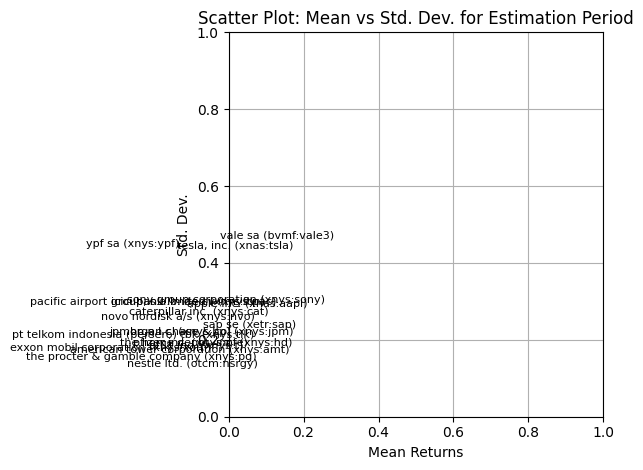

<ipython-input-14-df3d51c76ba9>:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


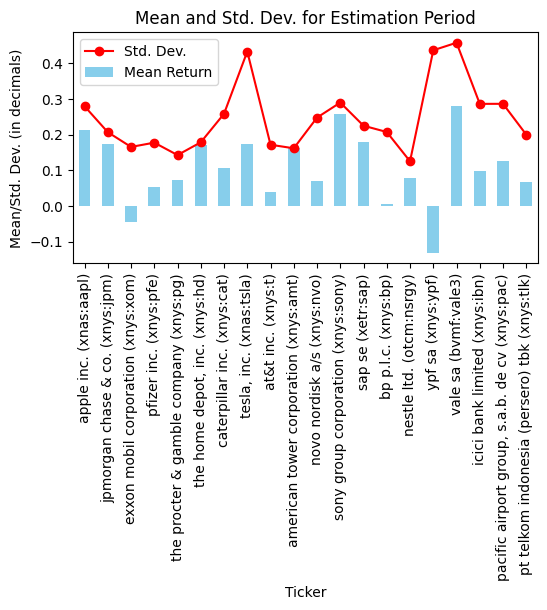

In [14]:
#Plot mean and std in one figure for estimation period
# Step 1: Combine the two series into a DataFrame
df = pd.concat([mu.rename('mu'), annualized_std.rename('annualized_std')], axis=1).dropna()

# Scatter plot (mu vs. annualized_std)
for ticker, row in df.iterrows():
    plt.text(row['mu'], row['annualized_std'], ticker, fontsize=8, ha='right', va='bottom')

plt.xlabel('Mean Returns')
plt.ylabel('Std. Dev.')
plt.title('Scatter Plot: Mean vs Std. Dev. for Estimation Period')
plt.grid(True)
plt.tight_layout()
plt.show()

# Bar + line plot by ticker
plt.figure(figsize=(6, 3))

# Bar plot for mu
df['mu'].plot(kind='bar', color='skyblue', label='Mean Return')

# Line plot for annualized_std (secondary axis)
plt.plot(df.index, df['annualized_std'], color='red', marker='o', label='Std. Dev.')

plt.xlabel('Ticker')
plt.ylabel('Mean/Std. Dev. (in decimals)')
plt.title('Mean and Std. Dev. for Estimation Period')
plt.legend()
plt.tight_layout()
plt.show()

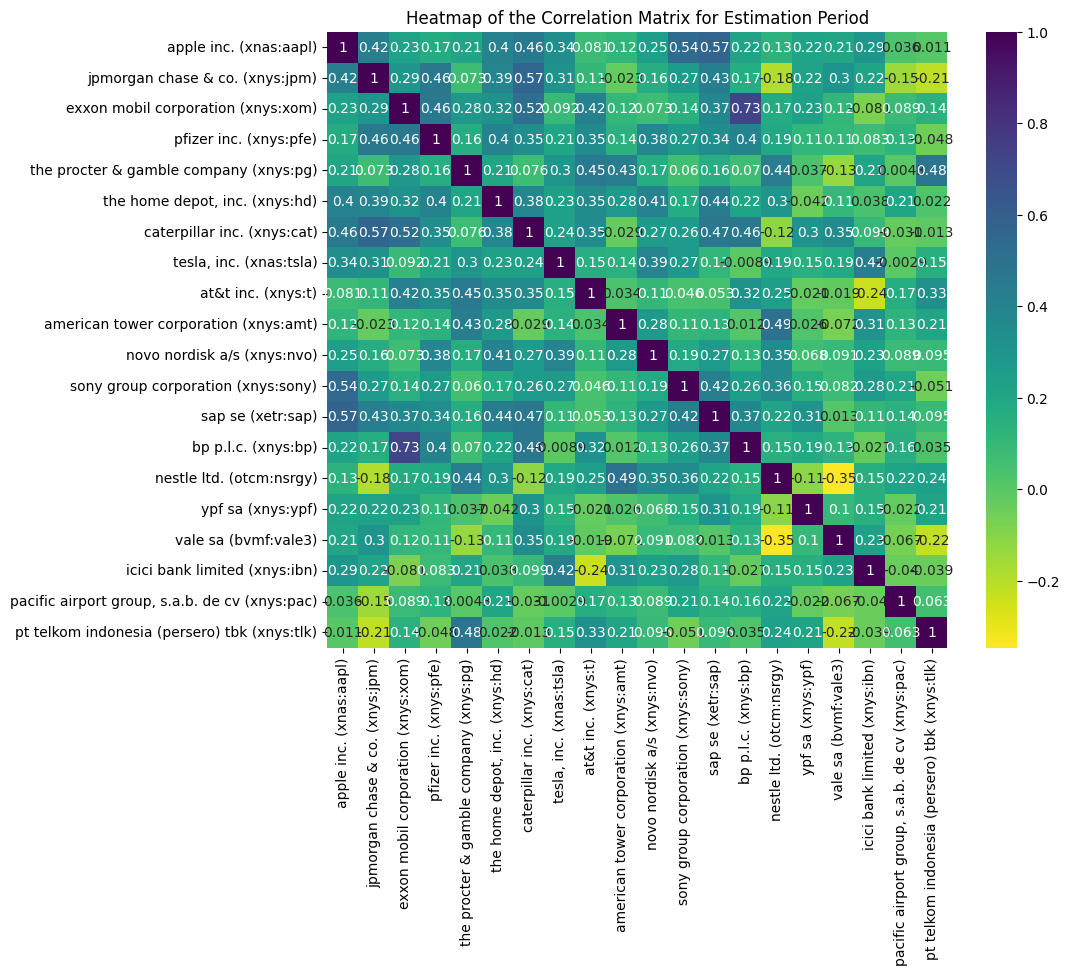

In [15]:
#covariance
S = risk_models.sample_cov(df_est.iloc[:, 1:], returns_data=True, frequency=12) #annualized
#correlation matrix
rho = risk_models.cov_to_corr(S)

# plot a heat map of the correlation matrix
plt.figure(figsize=(10, 8))  # Set the size of the figure
sns.heatmap(rho, annot=True, cmap='viridis_r')  # annot=True to display the values

# Show the heatmap
plt.title('Heatmap of the Correlation Matrix for Estimation Period')
plt.show()

In [16]:
#test/evaluation sample: (last five years)
df_eva = ret[(ret['date']>=datetime.datetime(eva_begyr, 1, 31)) & (ret['date']<=datetime.datetime(eva_endyr, 12, 31))].copy()
df_eva

,date,apple inc. (xnas:aapl),jpmorgan chase & co. (xnys:jpm),exxon mobil corporation (xnys:xom),pfizer inc. (xnys:pfe),the procter & gamble company (xnys:pg),"the home depot, inc. (xnys:hd)",caterpillar inc. (xnys:cat),"tesla, inc. (xnas:tsla)",at&t inc. (xnys:t),...,novo nordisk a/s (xnys:nvo),sony group corporation (xnys:sony),sap se (xetr:sap),bp p.l.c. (xnys:bp),nestle ltd. (otcm:nsrgy),ypf sa (xnys:ypf),vale sa (bvmf:vale3),icici bank limited (xnys:ibn),"pacific airport group, s.a.b. de cv (xnys:pac)",pt telkom indonesia (persero) tbk (xnys:tlk)
61,2020-01-31,0.098700,0.024437,0.011797,0.016529,-0.012964,0.021701,0.040078,0.318892,0.022530,...,0.006697,0.042879,-0.014239,0.046913,0.041225,0.155280,0.050429,0.014966,0.218426,-0.016955
62,2020-02-29,0.040613,-0.043227,-0.116735,-0.043360,0.016642,0.041886,-0.115131,0.468676,-0.036949,...,0.065126,0.030837,-0.021916,-0.069534,0.010540,-0.158602,-0.068027,-0.022788,0.022651,-0.029567
63,2020-03-31,-0.066167,-0.183439,-0.232292,-0.059490,-0.023752,0.001797,-0.075676,0.081393,-0.015839,...,0.028271,-0.101140,-0.087421,-0.135068,-0.021495,-0.222577,-0.112617,-0.114540,-0.151914,-0.064563
64,2020-04-30,-0.164821,-0.222335,-0.177815,-0.039458,-0.054085,-0.217977,-0.055514,-0.317697,-0.258226,...,-0.043478,-0.088748,-0.094587,-0.208960,-0.029011,-0.402740,-0.092127,-0.439969,-0.564854,-0.253587
65,2020-05-31,0.197514,0.109459,0.100230,0.118846,0.015120,0.223111,-0.033051,0.460938,0.088717,...,0.060160,0.091304,0.119055,-0.076456,-0.003627,-0.188073,0.107688,0.294606,0.285364,0.096623
66,2020-06-30,0.146811,0.192815,0.230413,-0.043722,0.012926,0.166217,0.218615,0.262888,0.096103,...,0.016709,0.072510,0.111988,0.213754,0.018873,0.621469,0.217341,0.043803,0.350460,0.093794
67,2020-07-31,0.098335,-0.166951,-0.169555,-0.041325,0.021550,-0.025108,-0.054766,0.364837,-0.082020,...,0.028837,0.043834,0.053162,-0.155179,0.050118,0.010453,0.011902,-0.014330,-0.104499,-0.026418
68,2020-08-31,0.167307,0.042953,-0.045372,0.115255,0.084712,0.068370,0.040401,0.183668,-0.016725,...,-0.015371,0.109609,0.048597,-0.058522,0.055247,0.074138,0.098653,-0.024922,-0.054399,-0.087633
69,2020-09-30,0.138340,0.071192,-0.071293,-0.055099,0.052166,0.015707,0.115141,0.461942,-0.005372,...,-0.003367,-0.003849,-0.006877,-0.068058,0.014171,-0.130016,-0.003626,0.099042,0.132817,-0.042418
70,2020-10-31,-0.065642,-0.054386,-0.156090,0.000580,0.001160,0.035786,0.011877,-0.007745,-0.025203,...,0.054361,-0.047006,-0.000753,-0.179649,0.002175,-0.330258,-0.035875,-0.007752,0.088436,-0.075866


In [17]:
#Descriptive statistics for the evaluation period
#mean return or historical average
mu = expected_returns.mean_historical_return(df_eva.iloc[:, 1:], returns_data=True, compounding=False, frequency=12) #annualized
print("Mean return of each stock during test period:\n", mu)

Mean return of each stock during test period:
 apple inc. (xnas:aapl)                            0.300039
jpmorgan chase & co. (xnys:jpm)                   0.164322
exxon mobil corporation (xnys:xom)                0.166416
pfizer inc. (xnys:pfe)                           -0.041109
the procter & gamble company (xnys:pg)            0.078685
the home depot, inc. (xnys:hd)                    0.179673
caterpillar inc. (xnys:cat)                       0.255863
tesla, inc. (xnas:tsla)                           0.887352
at&t inc. (xnys:t)                               -0.006121
american tower corporation (xnys:amt)             0.031743
novo nordisk a/s (xnys:nvo)                       0.301329
sony group corporation (xnys:sony)                0.140603
sap se (xetr:sap)                                 0.177586
bp p.l.c. (xnys:bp)                               0.015407
nestle ltd. (otcm:nsrgy)                         -0.026701
ypf sa (xnys:ypf)                                 0.521263
vale sa (

In [18]:
#std deviation
standard_deviation = df_eva.iloc[:, 1:].std()
annualized_std = standard_deviation * (12 ** 0.5)
print("Standard deviation of each stock during test period:\n", annualized_std)

Standard deviation of each stock during test period:
 apple inc. (xnas:aapl)                            0.294613
jpmorgan chase & co. (xnys:jpm)                   0.293063
exxon mobil corporation (xnys:xom)                0.380817
pfizer inc. (xnys:pfe)                            0.238788
the procter & gamble company (xnys:pg)            0.151800
the home depot, inc. (xnys:hd)                    0.282518
caterpillar inc. (xnys:cat)                       0.329905
tesla, inc. (xnas:tsla)                           0.819554
at&t inc. (xnys:t)                                0.248350
american tower corporation (xnys:amt)             0.274925
novo nordisk a/s (xnys:nvo)                       0.232996
sony group corporation (xnys:sony)                0.305097
sap se (xetr:sap)                                 0.281815
bp p.l.c. (xnys:bp)                               0.381201
nestle ltd. (otcm:nsrgy)                          0.164417
ypf sa (xnys:ypf)                                 0.731363
va

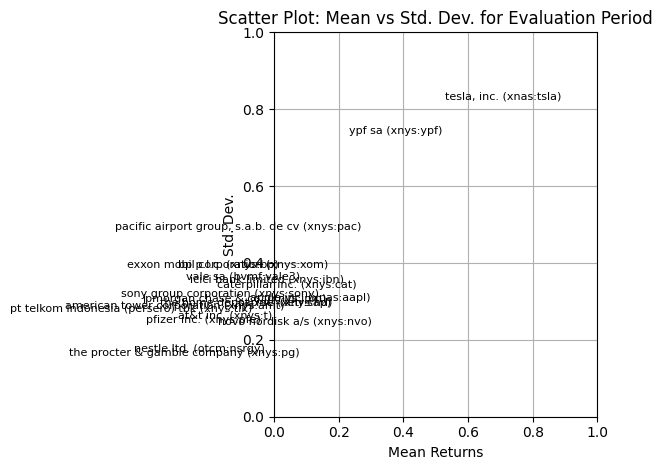

<ipython-input-19-9eecc44a701c>:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


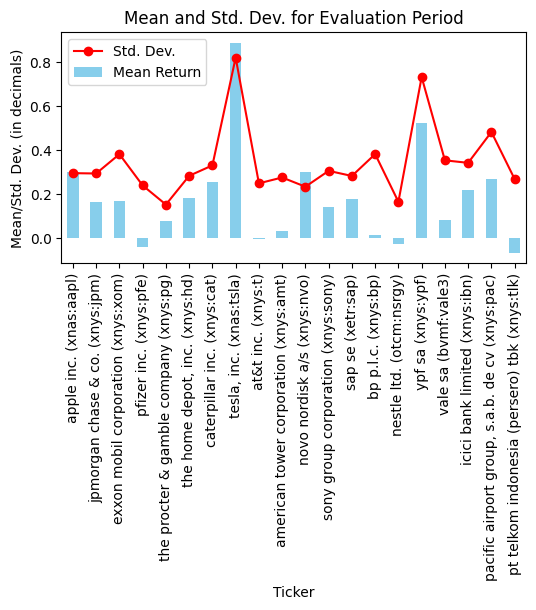

In [19]:
#Plot mean and std in one figure for evaluation period
# Step 1: Combine the two series into a DataFrame
df = pd.concat([mu.rename('mu'), annualized_std.rename('annualized_std')], axis=1).dropna()

# Scatter plot (mu vs. annualized_std)
for ticker, row in df.iterrows():
    plt.text(row['mu'], row['annualized_std'], ticker, fontsize=8, ha='right', va='bottom')

plt.xlabel('Mean Returns')
plt.ylabel('Std. Dev.')
plt.title('Scatter Plot: Mean vs Std. Dev. for Evaluation Period')
plt.grid(True)
plt.tight_layout()
plt.show()

# Bar + line plot by ticker
plt.figure(figsize=(6, 3))

# Bar plot for mu
df['mu'].plot(kind='bar', color='skyblue', label='Mean Return')

# Line plot for annualized_std (secondary axis)
plt.plot(df.index, df['annualized_std'], color='red', marker='o', label='Std. Dev.')

plt.xlabel('Ticker')
plt.ylabel('Mean/Std. Dev. (in decimals)')
plt.title('Mean and Std. Dev. for Evaluation Period')
plt.legend()
plt.tight_layout()
plt.show()

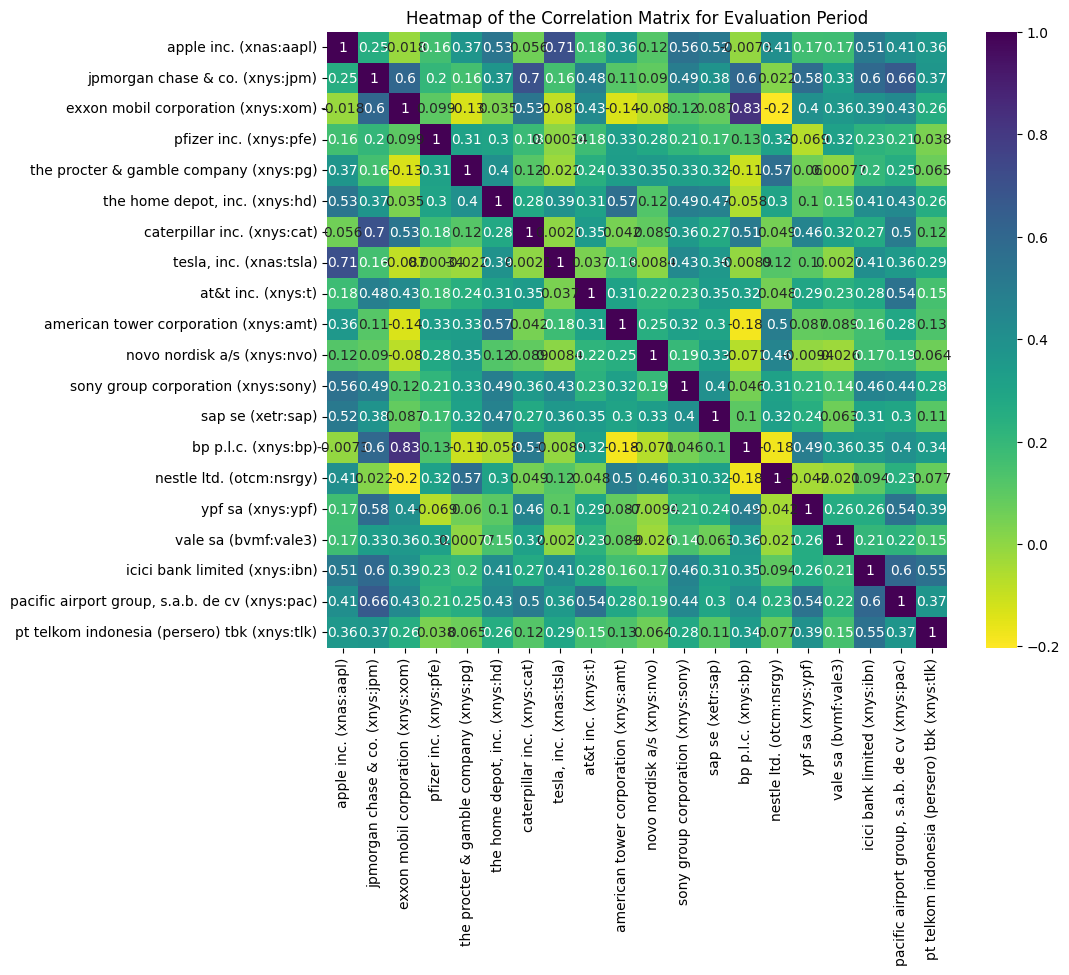

In [20]:
#covariance
S = risk_models.sample_cov(df_eva.iloc[:, 1:], returns_data=True, frequency=12) #annualized
#correlation matrix
rho = risk_models.cov_to_corr(S)

# plot a heat map of the correlation matrix
plt.figure(figsize=(10, 8))  # Set the size of the figure
sns.heatmap(rho, annot=True, cmap='viridis_r')  # annot=True to display the values

# Show the heatmap
plt.title('Heatmap of the Correlation Matrix for Evaluation Period')
plt.show()

#Stock weights based on alternative weighting methods using estimation sample

In [21]:
#weights of global minimum variance
#step 1: calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(df_est.iloc[:,1:], returns_data=True, compounding=False, frequency=12) #annualized
S = risk_models.sample_cov(df_est.iloc[:,1:], returns_data=True, frequency=12) #annualized
###
#step 2: Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1)) #default contraints
raw_weights = ef.min_volatility()
###
#step 3: convert ordered dictionary into dataframe
w_gmv=pd.DataFrame(raw_weights, index=[0]) #use scalar value and pass an index
w_gmv #1XN vector

,apple inc. (xnas:aapl),jpmorgan chase & co. (xnys:jpm),exxon mobil corporation (xnys:xom),pfizer inc. (xnys:pfe),the procter & gamble company (xnys:pg),"the home depot, inc. (xnys:hd)",caterpillar inc. (xnys:cat),"tesla, inc. (xnas:tsla)",at&t inc. (xnys:t),american tower corporation (xnys:amt),novo nordisk a/s (xnys:nvo),sony group corporation (xnys:sony),sap se (xetr:sap),bp p.l.c. (xnys:bp),nestle ltd. (otcm:nsrgy),ypf sa (xnys:ypf),vale sa (bvmf:vale3),icici bank limited (xnys:ibn),"pacific airport group, s.a.b. de cv (xnys:pac)",pt telkom indonesia (persero) tbk (xnys:tlk)
0,0.0,0.183904,0.0,0.0,0.036165,0.0,0.0,0.0,0.031954,0.052081,0.0,0.0,0.0,0.041983,0.403662,0.005342,0.059404,0.000256,0.04988,0.135369


<ipython-input-22-02ba7d163268>:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


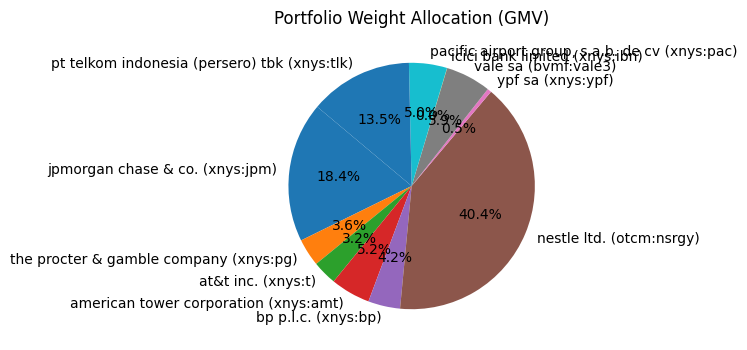

In [22]:
# Plot the weights of GMV portfolio
# Prepare data for pie chart: transpose and get the first row
weights = w_gmv.iloc[0]

# Optional: remove zero weights
weights = weights[weights > 0]

# Plot pie chart
plt.figure(figsize=(4, 4))
weights.plot(kind='pie', autopct='%1.1f%%', startangle=140)

plt.title('Portfolio Weight Allocation (GMV)')
plt.ylabel('')  # Hide y-axis label
plt.tight_layout()
plt.show()

In [23]:
# weights of maximal sharpe ratio
#step 1 (skipped): calculate expected returns and sample covariance
###
#step 2: Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1)) #default contraints
raw_weights = ef.max_sharpe()
###
#step 3: convert ordered dictionary into dataframe
w_mspr=pd.DataFrame(raw_weights, index=[0]) #use scalar value and pass an index
w_mspr #1XN vector

,apple inc. (xnas:aapl),jpmorgan chase & co. (xnys:jpm),exxon mobil corporation (xnys:xom),pfizer inc. (xnys:pfe),the procter & gamble company (xnys:pg),"the home depot, inc. (xnys:hd)",caterpillar inc. (xnys:cat),"tesla, inc. (xnas:tsla)",at&t inc. (xnys:t),american tower corporation (xnys:amt),novo nordisk a/s (xnys:nvo),sony group corporation (xnys:sony),sap se (xetr:sap),bp p.l.c. (xnys:bp),nestle ltd. (otcm:nsrgy),ypf sa (xnys:ypf),vale sa (bvmf:vale3),icici bank limited (xnys:ibn),"pacific airport group, s.a.b. de cv (xnys:pac)",pt telkom indonesia (persero) tbk (xnys:tlk)
0,0.0,0.185779,0.0,0.0,0.0,0.083702,0.0,0.0,0.0,0.282609,0.0,0.094251,0.006175,0.0,0.086895,0.0,0.078536,0.0,0.05816,0.123893


<ipython-input-24-b92bfafb917c>:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


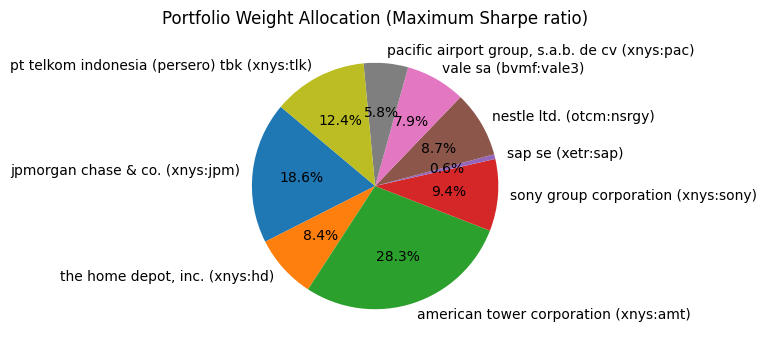

In [24]:
# Plot the weights of max Sharpe ratio portfolio
# Prepare data for pie chart: transpose and get the first row
weights = w_mspr.iloc[0]

# Optional: remove zero weights
weights = weights[weights > 0]

# Plot pie chart
plt.figure(figsize=(4, 4))
weights.plot(kind='pie', autopct='%1.1f%%', startangle=140)

plt.title('Portfolio Weight Allocation (Maximum Sharpe ratio)')
plt.ylabel('')  # Hide y-axis label
plt.tight_layout()
plt.show()

In [25]:
# weights of maximal utility
#step 1 (skipped): calculate expected returns and sample covariance
###
#step 2: Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1)) #default contraints
raw_weights = ef.max_quadratic_utility(risk_aversion=2) #default value =1
###
#step 3: convert ordered dictionary into dataframe
w_maxu=pd.DataFrame(raw_weights, index=[0]) #use scalar value and pass an index
w_maxu #1XN vector

,apple inc. (xnas:aapl),jpmorgan chase & co. (xnys:jpm),exxon mobil corporation (xnys:xom),pfizer inc. (xnys:pfe),the procter & gamble company (xnys:pg),"the home depot, inc. (xnys:hd)",caterpillar inc. (xnys:cat),"tesla, inc. (xnas:tsla)",at&t inc. (xnys:t),american tower corporation (xnys:amt),novo nordisk a/s (xnys:nvo),sony group corporation (xnys:sony),sap se (xetr:sap),bp p.l.c. (xnys:bp),nestle ltd. (otcm:nsrgy),ypf sa (xnys:ypf),vale sa (bvmf:vale3),icici bank limited (xnys:ibn),"pacific airport group, s.a.b. de cv (xnys:pac)",pt telkom indonesia (persero) tbk (xnys:tlk)
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.141288,0.0,0.578568,0.0,0.0,0.0,0.0,0.280144,0.0,0.0,0.0


<ipython-input-26-7ca831c2ac81>:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


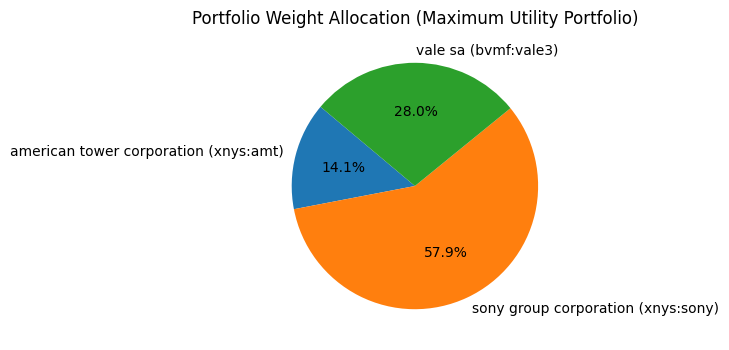

In [26]:
# Plot the weights of max utility portfolio
# Prepare data for pie chart: transpose and get the first row
weights = w_maxu.iloc[0]

# Optional: remove zero weights
weights = weights[weights > 0]

# Plot pie chart
plt.figure(figsize=(4, 4))
weights.plot(kind='pie', autopct='%1.1f%%', startangle=140)

plt.title('Portfolio Weight Allocation (Maximum Utility Portfolio)')
plt.ylabel('')  # Hide y-axis label
plt.tight_layout()
plt.show()

In [27]:
#value weighted as of end of 12/2019
mktcap_raw = pd.read_csv("marketcap.csv", parse_dates=True)
mktcap_raw.columns = map(str.lower, mktcap_raw.columns)#convert variable names to lower cases
mktcap_raw['date'] = pd.to_datetime(mktcap_raw['date'])+MonthEnd(0) #last calendar day of a month

if sample == 'US':
   mktcap = mktcap_raw.iloc[:, list(range(0, 11))]  #portfolio formed using the first 10 US stocks;
elif sample == 'GLOBAL' :
   mktcap = mktcap_raw.copy()  #portfolio formed using all stocks, including 10 US stocks and 5 foreign stocks;
else:
    print('Sample name is not provided')
mktcap

<ipython-input-27-6aa1aca3b39b>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mktcap_raw['date'] = pd.to_datetime(mktcap_raw['date'])+MonthEnd(0) #last calendar day of a month


,date,apple inc. (xnas:aapl),jpmorgan chase & co. (xnys:jpm),exxon mobil corporation (xnys:xom),pfizer inc. (xnys:pfe),the procter & gamble company (xnys:pg),"the home depot, inc. (xnys:hd)",caterpillar inc. (xnys:cat),"tesla, inc. (xnas:tsla)",at&t inc. (xnys:t),...,novo nordisk a/s (xnys:nvo),sony group corporation (xnys:sony),sap se (xnys:sap),bp p.l.c. (xlon:bp.),nestle ltd. (otcm:nsrgy),ypf sa (xnys:ypf),vale sa (xnys:vale),icici bank limited (xnys:ibn),"pacific airport group, s.a.b. de cv (xnys:pac)",pt telkom indonesia (persero) tbk (xnys:tlk)
0,2014-12-31,259.9694,142.674036,212.972378,83.223514,270.255503,267.595646,261.265741,137.253286,44.249360,...,112.139265,60.199806,312.720401,172.984949,155.566251,74.191246,189.773379,164.349879,284.937581,115.904364
1,2015-01-31,222.5809,112.441524,182.945546,62.858618,222.877103,250.854399,214.873104,102.246966,35.282364,...,84.117729,58.492045,256.039330,131.478296,135.337486,68.471233,167.803427,145.310776,222.092211,109.245866
2,2015-02-28,217.0124,103.054557,186.111861,67.373024,234.294833,247.760365,190.777281,104.434969,37.901638,...,93.760320,50.826601,235.042648,131.096228,136.767112,63.652071,176.157754,145.063974,224.044765,99.218672
3,2015-03-31,217.6488,103.174361,195.593299,70.733257,210.483704,268.372521,192.127109,107.197272,36.851174,...,94.969527,50.685109,231.249091,132.810593,142.254761,60.369382,158.536027,142.603222,208.752623,95.759695
4,2015-04-30,217.6488,109.162399,190.690773,68.156303,223.603657,260.539228,171.333819,109.400890,35.747816,...,89.555602,54.654051,251.222651,135.175062,131.202071,62.572538,158.885952,136.985218,226.466863,94.961446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2024-08-31,2497.2336,1271.592091,2177.001130,834.599086,2824.351709,2853.798143,2347.579762,1141.416587,443.381338,...,1059.760092,645.887948,2661.618464,1717.645902,1478.286353,698.581816,2020.677287,1562.431644,2804.425893,1143.437423
117,2024-09-30,2195.1027,1026.954692,1909.962560,678.170054,2247.350921,2406.996382,1999.655958,1022.484157,337.578786,...,768.408846,518.960176,2218.407934,1377.163359,1315.102114,644.907491,1768.264904,1380.793218,2272.852804,1062.473631
118,2024-10-31,2435.6619,1182.522312,2134.251218,795.462972,2538.837617,2823.791228,2197.505953,1257.710546,378.088071,...,979.033537,604.304808,2601.940731,1640.909935,1502.463976,761.382356,1742.755555,1654.214401,2724.648925,1119.998541
119,2024-11-30,2355.1573,1166.718964,2042.238503,741.296924,2360.473016,2519.062202,2154.467544,1059.957275,397.820507,...,885.565175,634.315728,2616.290450,1531.491516,1484.853481,736.769436,1702.945602,1641.791683,2501.214125,1186.128816


In [28]:
#calculate each stock's market share
#for each month, sum up market caps across all stocks
totcap = mktcap.iloc[:, 1:].sum(axis=1) #calculate end-of-month total market cap of the value-weighted portfolio;
totcap

,0
0,3398.521562
1,2846.788465
2,2806.667313
3,2782.240498
4,2795.022596
...,...
116,32915.158275
117,27778.327114
118,31737.215241
119,30444.264506


In [29]:
#copy to keep the columns
vw = mktcap.copy()
#cal. weight and replace mkt cap with weight
vw.iloc[:, 1:] = mktcap.iloc[:, 1:].div(totcap, axis=0)
vw

,date,apple inc. (xnas:aapl),jpmorgan chase & co. (xnys:jpm),exxon mobil corporation (xnys:xom),pfizer inc. (xnys:pfe),the procter & gamble company (xnys:pg),"the home depot, inc. (xnys:hd)",caterpillar inc. (xnys:cat),"tesla, inc. (xnas:tsla)",at&t inc. (xnys:t),...,novo nordisk a/s (xnys:nvo),sony group corporation (xnys:sony),sap se (xnys:sap),bp p.l.c. (xlon:bp.),nestle ltd. (otcm:nsrgy),ypf sa (xnys:ypf),vale sa (xnys:vale),icici bank limited (xnys:ibn),"pacific airport group, s.a.b. de cv (xnys:pac)",pt telkom indonesia (persero) tbk (xnys:tlk)
0,2014-12-31,0.076495,0.041981,0.062666,0.024488,0.079521,0.078739,0.076876,0.040386,0.013020,...,0.032996,0.017714,0.092017,0.050900,0.045775,0.021830,0.055840,0.048359,0.083842,0.034104
1,2015-01-31,0.078187,0.039498,0.064264,0.022081,0.078291,0.088118,0.075479,0.035917,0.012394,...,0.029548,0.020547,0.089940,0.046185,0.047540,0.024052,0.058945,0.051044,0.078015,0.038375
2,2015-02-28,0.077320,0.036718,0.066311,0.024005,0.083478,0.088276,0.067973,0.037210,0.013504,...,0.033406,0.018109,0.083744,0.046709,0.048729,0.022679,0.062764,0.051685,0.079826,0.035351
3,2015-03-31,0.078228,0.037083,0.070301,0.025423,0.075653,0.096459,0.069055,0.038529,0.013245,...,0.034134,0.018217,0.083116,0.047735,0.051130,0.021698,0.056981,0.051255,0.075030,0.034418
4,2015-04-30,0.077870,0.039056,0.068225,0.024385,0.080001,0.093215,0.061300,0.039141,0.012790,...,0.032041,0.019554,0.089882,0.048363,0.046941,0.022387,0.056846,0.049010,0.081025,0.033975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2024-08-31,0.075869,0.038632,0.066140,0.025356,0.085807,0.086702,0.071322,0.034678,0.013470,...,0.032197,0.019623,0.080863,0.052184,0.044912,0.021224,0.061390,0.047468,0.085202,0.034739
117,2024-09-30,0.079022,0.036970,0.068757,0.024414,0.080903,0.086650,0.071986,0.036809,0.012153,...,0.027662,0.018682,0.079861,0.049577,0.047343,0.023216,0.063656,0.049708,0.081821,0.038248
118,2024-10-31,0.076745,0.037260,0.067248,0.025064,0.079996,0.088974,0.069241,0.039629,0.011913,...,0.030848,0.019041,0.081984,0.051703,0.047341,0.023990,0.054912,0.052122,0.085850,0.035290
119,2024-11-30,0.077360,0.038323,0.067081,0.024349,0.077534,0.082743,0.070768,0.034816,0.013067,...,0.029088,0.020835,0.085937,0.050305,0.048773,0.024201,0.055937,0.053928,0.082157,0.038961


In [30]:
#value-weigted as of Dec 31/2019
w_vw = vw[vw['date']==datetime.datetime(est_endyr, 12, 31)] #keep weights as of 12/31/2019
w_vw = w_vw.drop('date', axis=1)
w_vw

,apple inc. (xnas:aapl),jpmorgan chase & co. (xnys:jpm),exxon mobil corporation (xnys:xom),pfizer inc. (xnys:pfe),the procter & gamble company (xnys:pg),"the home depot, inc. (xnys:hd)",caterpillar inc. (xnys:cat),"tesla, inc. (xnas:tsla)",at&t inc. (xnys:t),american tower corporation (xnys:amt),novo nordisk a/s (xnys:nvo),sony group corporation (xnys:sony),sap se (xnys:sap),bp p.l.c. (xlon:bp.),nestle ltd. (otcm:nsrgy),ypf sa (xnys:ypf),vale sa (xnys:vale),icici bank limited (xnys:ibn),"pacific airport group, s.a.b. de cv (xnys:pac)",pt telkom indonesia (persero) tbk (xnys:tlk)
60,0.076796,0.037748,0.075214,0.025178,0.082439,0.084799,0.074808,0.034955,0.013345,0.022758,0.030213,0.018828,0.083509,0.045674,0.046654,0.024341,0.057865,0.050307,0.076026,0.038543


<ipython-input-31-f531cb76549b>:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


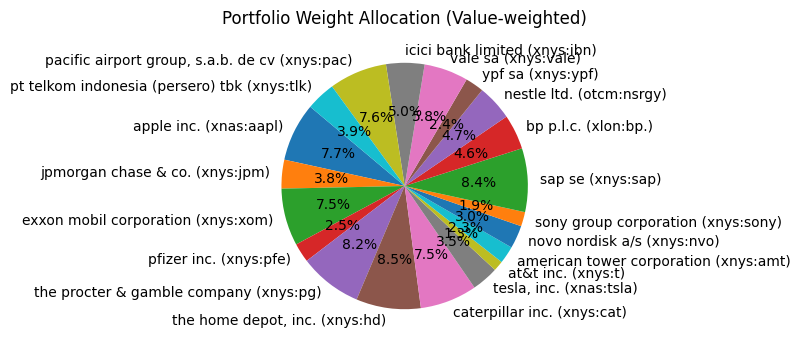

In [31]:
# Plot the weights of max Sharpe ratio portfolio
# Prepare data for pie chart: transpose and get the first row
weights = w_vw.iloc[0]

# Optional: remove zero weights
weights = weights[weights > 0]

# Plot pie chart
plt.figure(figsize=(4, 4))
weights.plot(kind='pie', autopct='%1.1f%%', startangle=140)

plt.title('Portfolio Weight Allocation (Value-weighted)')
plt.ylabel('')  # Hide y-axis label
plt.tight_layout()
plt.show()

In [32]:
#value-weigted as of Dec 31/2019
w_vw = vw[vw['date']==datetime.datetime(est_endyr, 12, 31)] #keep weights as of 12/31/2019
w_vw = w_vw.drop('date', axis=1)
# Ensure w_vw has the same columns as df_eva
w_vw = w_vw.reindex(columns=df_eva.columns[1:])  # Reindex columns to match df_eva
w_vw = w_vw.fillna(0)  # Fill any missing values with 0
w_vw

,apple inc. (xnas:aapl),jpmorgan chase & co. (xnys:jpm),exxon mobil corporation (xnys:xom),pfizer inc. (xnys:pfe),the procter & gamble company (xnys:pg),"the home depot, inc. (xnys:hd)",caterpillar inc. (xnys:cat),"tesla, inc. (xnas:tsla)",at&t inc. (xnys:t),american tower corporation (xnys:amt),novo nordisk a/s (xnys:nvo),sony group corporation (xnys:sony),sap se (xetr:sap),bp p.l.c. (xnys:bp),nestle ltd. (otcm:nsrgy),ypf sa (xnys:ypf),vale sa (bvmf:vale3),icici bank limited (xnys:ibn),"pacific airport group, s.a.b. de cv (xnys:pac)",pt telkom indonesia (persero) tbk (xnys:tlk)
60,0.076796,0.037748,0.075214,0.025178,0.082439,0.084799,0.074808,0.034955,0.013345,0.022758,0.030213,0.018828,0.0,0.0,0.046654,0.024341,0.0,0.050307,0.076026,0.038543


# Define performance evaluation function

In [33]:
def perf_eval(weight, outfile):
  #calculate ex-post monthly portfolio return for value-weighted portfolio
  r_p = pd.DataFrame() #create a dataframe to save monthly portfolio returns
  r_p['r_p'] = df_eva.iloc[:,1:].dot(weight.T) #matrix multiplication (df_eva is a TXN matrix, wt is a 1xN vector)
  r_p['date'] = df_eva['date'] #get the date variable from the test sample
  #r_p
  ##
  #merge portfolio, market, and risk-free return data
  tmp = r_p.merge(mktrf, how = 'inner') #add excess market return and risk-free rate
  tmp['r_p'] = (tmp['r_p'] - tmp['rf'])
  tmp = tmp.rename(columns = {'mkt_rf': 'r_m'}) #rename excess market return to r_m
  dport = tmp[['date', 'r_m', 'r_p']] #keep the variables of interest
  #data
  ##
  #summary stats
  stat = dport.iloc[:, 2:].describe()
  #stat = data.iloc[:, 1:].describe(percentiles = [0.01, 0.025, 0.05])
  #print(stat)
  ##
  #Sharpe ratio
  sharpe = stat.loc['mean']/stat.loc['std']
  sharpe = sharpe.rename('sharpe')
  #print(sharpe)
  ##
  #estimate market model
  dport['constant'] = 1
  Y = dport['r_p']
  X = dport[['constant', 'r_m']]
  result = sm.OLS(Y,X).fit()
  #print(result.summary())
  #keep the results of interest
  from statsmodels.iolib.summary2 import summary_col
  regout = summary_col(result, regressor_order=result.params.index.tolist())
  regout = regout.tables[0] #convert into a table
  ##
  #Treynor ratio
  tr = stat.loc[['mean'],['r_p']]/(result.params.loc['r_m'])
  tr = tr.rename(columns={'r_p':'tr'})
  tr = tr.reset_index(drop=True)
  #print(tr)
  ##
  #information ratio
  sig_e = (result.resid).std() #cal. std dev of reg residuals
  ir = regout.loc[['constant'],['r_p']].astype(float)/sig_e
  ir = ir.rename(columns={'r_p':'ir'})
  ir = ir.reset_index(drop=True)
  #print(ir)
  ##
  #save the results into a pre-specified Excel file
  # Create the file path by combining the working directory with the output file name
  file_path = os.path.join(output_folder_path, outfile + '.xlsx')
  # Write the results to the Excel file
  writer = pd.ExcelWriter(file_path, engine='openpyxl')
  stat.to_excel(writer, sheet_name='stat') #save the summary stats
  sharpe.to_excel(writer, sheet_name='sharpe') # save Sharpe ratio
  regout.to_excel(writer, sheet_name='regout') #save regression results
  tr.to_excel(writer, sheet_name='tr') #save Treyno ratio
  ir.to_excel(writer, sheet_name='ir') #save information ratio
  writer.close()

In [34]:
perf_eval(w_gmv, 'perf_eva_gmv') #global minimum variance portfolio
perf_eval(w_mspr, 'perf_eva_msrp') #maximum sharpe ratio portfolio
perf_eval(w_maxu, 'perf_eva_maxu') #maximum utility portfolio
perf_eval(w_vw, 'perf_eva_vw') #value-weighted portfolio